# Introduction to deep learning with pytorch

## Sources:

https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [1]:
# Imports

import torch
torch.manual_seed(0) # For reproducibility of results
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
## Dataset view: https://www.kaggle.com/datasets/zalando-research/fashionmnist

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create data loaders.

# We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Image shape (28, 28)


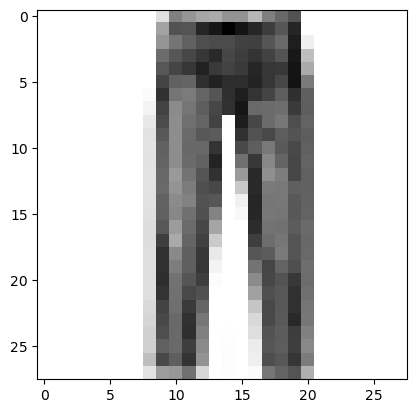

In [3]:
# Displaying sample the data using matplotlib

import matplotlib.pyplot as plt
import numpy as np

# matplotlib inline
sample_data = training_data[16]
image = sample_data[0].numpy()[0]
print(f"Image shape {image.shape}")
plt.imshow(image * 255, cmap='Greys')

# Model

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # convert each 2D 28x28 image into a contiguous array of 784 pixel values (the minibatch dimension (at dim=0) is maintained).
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), # images are 28x28 pixels
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
# Forward propagation on first data sample

X = sample_data[0].to(device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1).cpu().item()

print(f"Predicted class: {datasets.FashionMNIST.classes[y_pred]}, Actual class: {datasets.FashionMNIST.classes[sample_data[1]]}")

# Why wrong prediction? (depends on random initial weights) -> We havent trained our model yet

Predicted class: Ankle boot, Actual class: Trouser


In [6]:
loss_fn = nn.CrossEntropyLoss() # More about loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # More about optimizers: https://pytorch.org/docs/stable/optim.html

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # set model to training mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() # reset gradients

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # set model to evaluation mode
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
# Initial accuracy
test(test_dataloader, model, loss_fn)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Test Error: 
 Accuracy: 8.9%, Avg loss: 2.304297 

Epoch 1
-------------------------------
loss: 2.314872  [   64/60000]
loss: 0.555549  [ 6464/60000]
loss: 0.385013  [12864/60000]
loss: 0.497228  [19264/60000]
loss: 0.427932  [25664/60000]
loss: 0.448676  [32064/60000]
loss: 0.364214  [38464/60000]
loss: 0.523146  [44864/60000]
loss: 0.470050  [51264/60000]
loss: 0.540722  [57664/60000]
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.420927 

Epoch 2
-------------------------------
loss: 0.263710  [   64/60000]
loss: 0.368335  [ 6464/60000]
loss: 0.279124  [12864/60000]
loss: 0.384675  [19264/60000]
loss: 0.406725  [25664/60000]
loss: 0.424508  [32064/60000]
loss: 0.303943  [38464/60000]
loss: 0.490382  [44864/60000]
loss: 0.412547  [51264/60000]
loss: 0.454745  [57664/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.396090 

Epoch 3
-------------------------------
loss: 0.217470  [   64/60000]
loss: 0.339472  [ 6464/60000]
loss: 0.233601  [12864/60000]
loss: 0.326719  [19264/60000]
loss:

In [8]:
# Forward propagation on first data sample

X = sample_data[0].to(device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1).cpu().item()

print(f"Predicted class: {datasets.FashionMNIST.classes[y_pred]}, Actual class: {datasets.FashionMNIST.classes[sample_data[1]]}")

Predicted class: Trouser, Actual class: Trouser
